# Chapter 5: Categorical Variables

**Using Index Variables in Bayesian Regression**

## Goal

Learn how to incorporate **categorical predictors** into regression models using the **index variable** approach.

**Key concepts:**
- Index variables (not dummy variables!)
- Each category gets its own parameter
- Multiple regression with categorical + continuous predictors
- Interpreting category-specific effects

**Example**: Predicting height from sex and weight

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

plt.style.use('default')
%matplotlib inline

np.random.seed(42)

print('✓ Imports loaded')

✓ Imports loaded


In [2]:
# Import quap
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent.parent))
from src.quap import quap, QuapResult

print('✓ Loaded quap')

✓ Loaded quap


---

## Step 1: Load and Explore Data

Using the **!Kung San** data with adults only.

In [3]:
# Load Howell1 data
url = "https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/Howell1.csv"
howell_data = pd.read_csv(url, sep=";")

# Filter to adults only
adults = howell_data[howell_data['age'] >= 18].copy()

print(f"Dataset shape: {adults.shape}")
print(f"\nVariables: {list(adults.columns)}")
print(f"\nFirst few rows:")
adults.head()

Dataset shape: (352, 4)

Variables: ['height', 'weight', 'age', 'male']

First few rows:


,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [4]:
# Check sex distribution
print("Sex distribution:")
print(adults['male'].value_counts())
print(f"\n1 = Male, 2 = Female")
print(f"Males: {(adults['male'] == 1).sum()}")
print(f"Females: {(adults['male'] == 2).sum()}")

Sex distribution:
male
0    187
1    165
Name: count, dtype: int64

1 = Male, 2 = Female
Males: 165
Females: 0


In [5]:
# Extract variables
height = adults['height'].values
weight = adults['weight'].values
sex = adults['male'].values  # 1=male, 2=female

# Standardize continuous variables
height_std = (height - height.mean()) / height.std()
weight_std = (weight - weight.mean()) / weight.std()

# Keep sex as index (1 or 2)
sex_idx = sex  # Will use directly as index

print("Variables prepared:")
print(f"  Height: mean={height_std.mean():.3f}, std={height_std.std():.3f}")
print(f"  Weight: mean={weight_std.mean():.3f}, std={weight_std.std():.3f}")
print(f"  Sex: 1=Male ({(sex==1).sum()}), 2=Female ({(sex==2).sum()})")
print(f"\nSample size: {len(height)}")

Variables prepared:
  Height: mean=-0.000, std=1.000
  Weight: mean=0.000, std=1.000
  Sex: 1=Male (165), 2=Female (0)

Sample size: 352


### Exploratory Visualization

/tmp/ipykernel_1206713/1788709124.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([males, females], positions=positions, widths=0.5,
/tmp/ipykernel_1206713/1788709124.py:33: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp2 = ax.boxplot([males_w, females_w], positions=positions, widths=0.5,


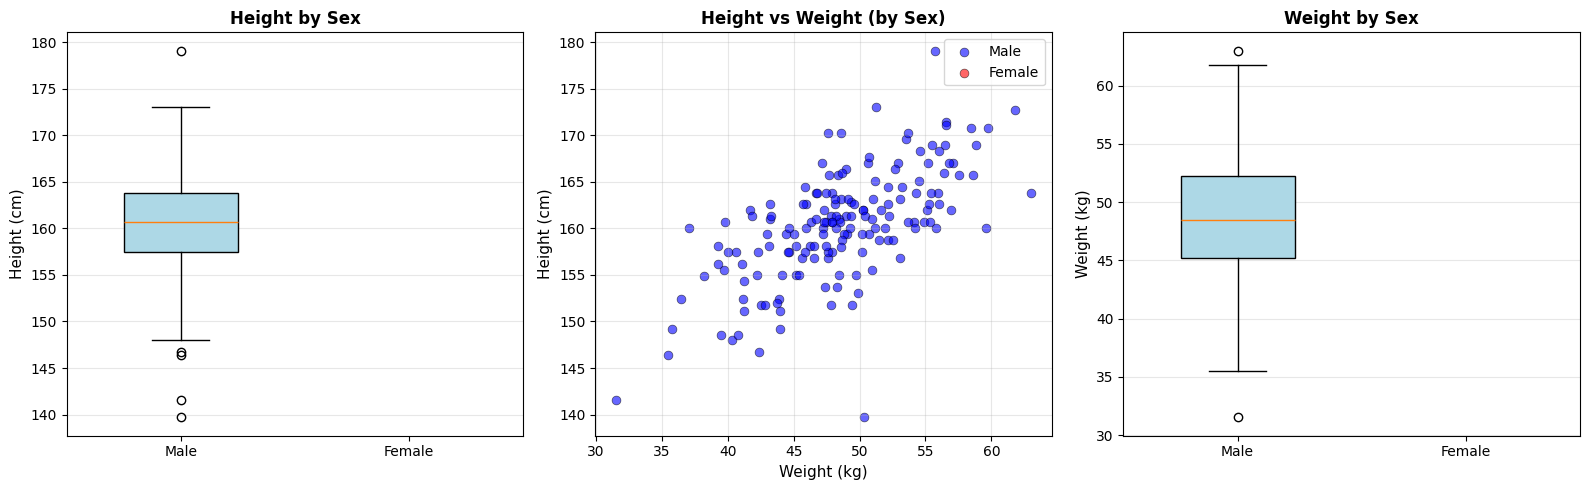

Summary statistics:

Males:
  Height: 160.4 ± 6.0 cm
  Weight: 48.6 ± 5.6 kg

Females:
  Height: nan ± nan cm
  Weight: nan ± nan kg


/tmp/ipykernel_1206713/1788709124.py:49: RuntimeWarning: Mean of empty slice.
  print(f"  Height: {females.mean():.1f} ± {females.std():.1f} cm")
/home/satishthakur/codebase/data-science/statistics/bayes-bda-rethinking/.venv/lib/python3.11/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/satishthakur/codebase/data-science/statistics/bayes-bda-rethinking/.venv/lib/python3.11/site-packages/numpy/_core/_methods.py:222: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/satishthakur/codebase/data-science/statistics/bayes-bda-rethinking/.venv/lib/python3.11/site-packages/numpy/_core/_methods.py:180: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/satishthakur/codebase/data-science/statistics/bayes-bda-rethinking/.venv/lib/python3.11/site-packages/numpy/_core/_methods.py

In [6]:
# Visualize relationships
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Plot 1: Height by Sex
ax = axes[0]
males = height[sex == 1]
females = height[sex == 2]
positions = [1, 2]
bp = ax.boxplot([males, females], positions=positions, widths=0.5,
                 patch_artist=True, labels=['Male', 'Female'])
bp['boxes'][0].set_facecolor('lightblue')
bp['boxes'][1].set_facecolor('lightpink')
ax.set_ylabel('Height (cm)', fontsize=11)
ax.set_title('Height by Sex', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Plot 2: Height vs Weight (colored by sex)
ax = axes[1]
ax.scatter(weight[sex == 1], height[sex == 1], s=40, alpha=0.6, 
          color='blue', label='Male', edgecolor='black', linewidth=0.5)
ax.scatter(weight[sex == 2], height[sex == 2], s=40, alpha=0.6, 
          color='red', label='Female', edgecolor='black', linewidth=0.5)
ax.set_xlabel('Weight (kg)', fontsize=11)
ax.set_ylabel('Height (cm)', fontsize=11)
ax.set_title('Height vs Weight (by Sex)', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 3: Weight by Sex
ax = axes[2]
males_w = weight[sex == 1]
females_w = weight[sex == 2]
bp2 = ax.boxplot([males_w, females_w], positions=positions, widths=0.5,
                  patch_artist=True, labels=['Male', 'Female'])
bp2['boxes'][0].set_facecolor('lightblue')
bp2['boxes'][1].set_facecolor('lightpink')
ax.set_ylabel('Weight (kg)', fontsize=11)
ax.set_title('Weight by Sex', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("Summary statistics:")
print(f"\nMales:")
print(f"  Height: {males.mean():.1f} ± {males.std():.1f} cm")
print(f"  Weight: {males_w.mean():.1f} ± {males_w.std():.1f} kg")
print(f"\nFemales:")
print(f"  Height: {females.mean():.1f} ± {females.std():.1f} cm")
print(f"  Weight: {females_w.mean():.1f} ± {females_w.std():.1f} kg")

---

## Step 2: Index Variable Approach

**Key idea**: Each category gets its own intercept parameter.

**Model**: height ~ Sex
```
h_i ~ Normal(μ_i, σ)
μ_i = α[sex[i]]     ← Index variable!
α[1] ~ Normal(0, 1)  ← Prior for males
α[2] ~ Normal(0, 1)  ← Prior for females
σ ~ Exponential(1)
```

**No dummy variables!** Each sex gets its own parameter.

In [7]:
# Model 1: Height ~ Sex (using index variables)
def neg_log_posterior_height_sex(params):
    alpha_1, alpha_2, log_sigma = params
    sigma = np.exp(log_sigma)
    
    # Create mu using index variable approach
    # For each observation, select the appropriate alpha
    mu = np.where(sex_idx == 1, alpha_1, alpha_2)
    
    # Likelihood
    log_lik = np.sum(stats.norm.logpdf(height_std, loc=mu, scale=sigma))
    
    # Priors
    log_prior = (stats.norm.logpdf(alpha_1, 0, 1) +   # Prior for male
                 stats.norm.logpdf(alpha_2, 0, 1) +   # Prior for female
                 stats.expon.logpdf(sigma, scale=1))
    
    return -(log_lik + log_prior + log_sigma)

m_sex = quap(neg_log_posterior_height_sex, [0, 0, np.log(1)], 
             ['alpha_male', 'alpha_female', 'log_sigma'])
m_sex.transform_param('log_sigma', 'sigma', np.exp)

print("Model 1: Height ~ Sex")
print("="*70)
m_sex.summary()

✓ Registered transformation: log_sigma -> sigma
Model 1: Height ~ Sex
QUAP POSTERIOR APPROXIMATION
Converged: True
Time: 0.0157 seconds
Log posterior at MAP: -384.34

                mean    std  89%_lower  89%_upper
alpha_male    0.7432 0.0557     0.6534     0.8316
alpha_female -0.6559 0.0521    -0.7389    -0.5742
sigma         0.7150 0.0268     0.6732     0.7588


,mean,std,89%_lower,89%_upper
alpha_male,0.743219,0.055746,0.653358,0.831601
alpha_female,-0.655879,0.052140,-0.738860,-0.574207
sigma,0.714994,0.026758,0.673206,0.758813


In [8]:
# Interpret the results
coef_sex = m_sex.coef()

# Convert back to original scale
height_mean_orig = height.mean()
height_std_orig = height.std()

male_height_est = coef_sex['alpha_male'] * height_std_orig + height_mean_orig
female_height_est = coef_sex['alpha_female'] * height_std_orig + height_mean_orig
height_diff = male_height_est - female_height_est

print("\nEstimated heights (original scale):")
print("="*70)
print(f"Male average:   {male_height_est:.1f} cm")
print(f"Female average: {female_height_est:.1f} cm")
print(f"Difference:     {height_diff:.1f} cm (males taller)")
print("\n✓ Each sex has its own intercept parameter!")


Estimated heights (original scale):
Male average:   160.3 cm
Female average: 149.5 cm
Difference:     10.8 cm (males taller)

✓ Each sex has its own intercept parameter!


---

## Step 3: Multiple Regression - Sex + Weight

**Model**: Height ~ Sex + Weight

```
h_i ~ Normal(μ_i, σ)
μ_i = α[sex[i]] + β * weight[i]
α[1] ~ Normal(0, 1)     ← Intercept for males
α[2] ~ Normal(0, 1)     ← Intercept for females
β ~ Normal(0, 1)        ← Slope (same for both sexes)
σ ~ Exponential(1)
```

**Key**: Each sex gets its own intercept, but they share the same slope!

In [9]:
# Model 2: Height ~ Sex + Weight
def neg_log_posterior_height_sex_weight(params):
    alpha_1, alpha_2, beta, log_sigma = params
    sigma = np.exp(log_sigma)
    
    # Index variable for intercept + common slope
    alpha_vec = np.where(sex_idx == 1, alpha_1, alpha_2)
    mu = alpha_vec + beta * weight_std
    
    # Likelihood
    log_lik = np.sum(stats.norm.logpdf(height_std, loc=mu, scale=sigma))
    
    # Priors
    log_prior = (stats.norm.logpdf(alpha_1, 0, 1) +
                 stats.norm.logpdf(alpha_2, 0, 1) +
                 stats.norm.logpdf(beta, 0, 1) +
                 stats.expon.logpdf(sigma, scale=1))
    
    return -(log_lik + log_prior + log_sigma)

m_sex_weight = quap(neg_log_posterior_height_sex_weight, [0, 0, 0, np.log(1)], 
                    ['alpha_male', 'alpha_female', 'beta_weight', 'log_sigma'])
m_sex_weight.transform_param('log_sigma', 'sigma', np.exp)

print("Model 2: Height ~ Sex + Weight")
print("="*70)
m_sex_weight.summary()

✓ Registered transformation: log_sigma -> sigma
Model 2: Height ~ Sex + Weight
QUAP POSTERIOR APPROXIMATION
Converged: True
Time: 0.0225 seconds
Log posterior at MAP: -293.39

                mean    std  89%_lower  89%_upper
alpha_male    0.4459 0.0469     0.3713     0.5209
alpha_female -0.3930 0.0433    -0.4632    -0.3244
beta_weight   0.5347 0.0348     0.4793     0.5894
sigma         0.5511 0.0210     0.5181     0.5848


,mean,std,89%_lower,89%_upper
alpha_male,0.445901,0.046881,0.371277,0.520932
alpha_female,-0.393023,0.043301,-0.463235,-0.324432
beta_weight,0.534727,0.034804,0.479306,0.589356
sigma,0.551118,0.020960,0.518094,0.584843


In [10]:
# Compare models
coef_sw = m_sex_weight.coef()

print("\nComparison: Sex only vs Sex + Weight")
print("="*70)
print("\nIntercepts (standardized scale):")
print(f"  Model 1 (Sex only):")
print(f"    α_male   = {coef_sex['alpha_male']:.3f}")
print(f"    α_female = {coef_sex['alpha_female']:.3f}")
print(f"\n  Model 2 (Sex + Weight):")
print(f"    α_male   = {coef_sw['alpha_male']:.3f}")
print(f"    α_female = {coef_sw['alpha_female']:.3f}")
print(f"    β_weight = {coef_sw['beta_weight']:.3f}")
print("\n✓ Adding weight improves the model and reduces sigma!")


Comparison: Sex only vs Sex + Weight

Intercepts (standardized scale):
  Model 1 (Sex only):
    α_male   = 0.743
    α_female = -0.656

  Model 2 (Sex + Weight):
    α_male   = 0.446
    α_female = -0.393
    β_weight = 0.535

✓ Adding weight improves the model and reduces sigma!


### Visualize the Multiple Regression

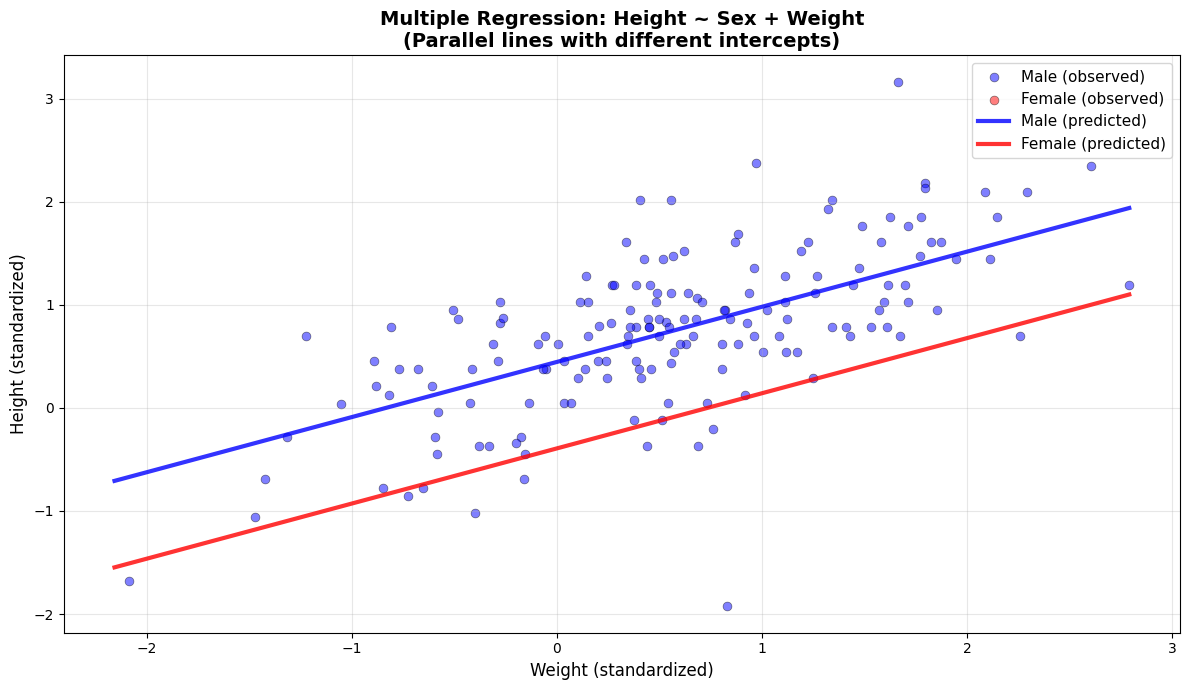


Key observations:
  • Lines are PARALLEL (same slope for both sexes)
  • Different INTERCEPTS (males higher than females)
  • Same effect of weight on height for both sexes


In [11]:
# Create prediction lines for each sex
weight_seq = np.linspace(weight_std.min(), weight_std.max(), 100)

# Predictions for males
mu_male = coef_sw['alpha_male'] + coef_sw['beta_weight'] * weight_seq

# Predictions for females
mu_female = coef_sw['alpha_female'] + coef_sw['beta_weight'] * weight_seq

# Plot
plt.figure(figsize=(12, 7))

# Scatter plots
plt.scatter(weight_std[sex == 1], height_std[sex == 1], s=40, alpha=0.5,
           color='blue', label='Male (observed)', edgecolor='black', linewidth=0.5)
plt.scatter(weight_std[sex == 2], height_std[sex == 2], s=40, alpha=0.5,
           color='red', label='Female (observed)', edgecolor='black', linewidth=0.5)

# Regression lines
plt.plot(weight_seq, mu_male, 'b-', linewidth=3, label='Male (predicted)', alpha=0.8)
plt.plot(weight_seq, mu_female, 'r-', linewidth=3, label='Female (predicted)', alpha=0.8)

plt.xlabel('Weight (standardized)', fontsize=12)
plt.ylabel('Height (standardized)', fontsize=12)
plt.title('Multiple Regression: Height ~ Sex + Weight\n(Parallel lines with different intercepts)', 
         fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nKey observations:")
print("  • Lines are PARALLEL (same slope for both sexes)")
print("  • Different INTERCEPTS (males higher than females)")
print("  • Same effect of weight on height for both sexes")

---

## Step 4: Sample from Posterior and Visualize Uncertainty

In [12]:
# Sample from posterior
post_sw = m_sex_weight.sample(n=1000, seed=42)

alpha_male_samples = post_sw['alpha_male'].values
alpha_female_samples = post_sw['alpha_female'].values
beta_weight_samples = post_sw['beta_weight'].values

# Compute prediction intervals
mu_male_samples = alpha_male_samples[:, None] + beta_weight_samples[:, None] * weight_seq[None, :]
mu_female_samples = alpha_female_samples[:, None] + beta_weight_samples[:, None] * weight_seq[None, :]

# Summary statistics
mu_male_mean = mu_male_samples.mean(axis=0)
mu_male_lower = np.percentile(mu_male_samples, 5.5, axis=0)
mu_male_upper = np.percentile(mu_male_samples, 94.5, axis=0)

mu_female_mean = mu_female_samples.mean(axis=0)
mu_female_lower = np.percentile(mu_female_samples, 5.5, axis=0)
mu_female_upper = np.percentile(mu_female_samples, 94.5, axis=0)

print(f"✓ Generated {len(alpha_male_samples)} posterior samples")

✓ Generated 1000 posterior samples


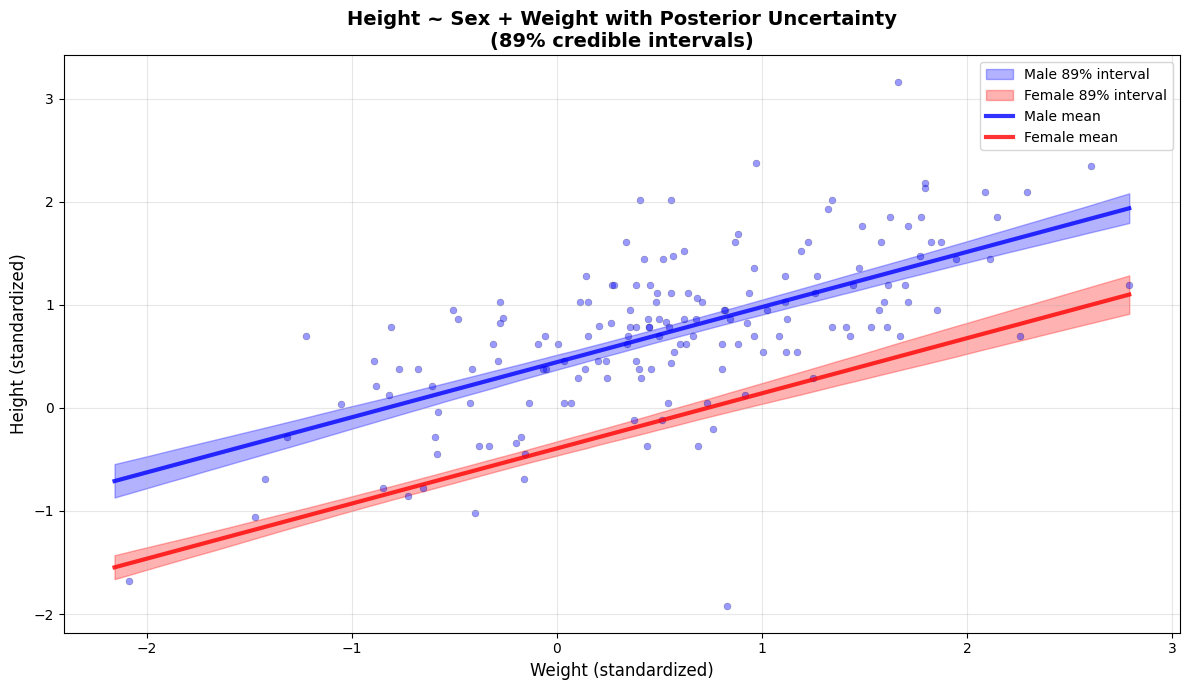

In [13]:
# Plot with uncertainty
plt.figure(figsize=(12, 7))

# Uncertainty bands
plt.fill_between(weight_seq, mu_male_lower, mu_male_upper, 
                alpha=0.3, color='blue', label='Male 89% interval')
plt.fill_between(weight_seq, mu_female_lower, mu_female_upper, 
                alpha=0.3, color='red', label='Female 89% interval')

# Mean lines
plt.plot(weight_seq, mu_male_mean, 'b-', linewidth=3, label='Male mean', alpha=0.8)
plt.plot(weight_seq, mu_female_mean, 'r-', linewidth=3, label='Female mean', alpha=0.8)

# Scatter plots
plt.scatter(weight_std[sex == 1], height_std[sex == 1], s=25, alpha=0.4,
           color='blue', edgecolor='black', linewidth=0.3)
plt.scatter(weight_std[sex == 2], height_std[sex == 2], s=25, alpha=0.4,
           color='red', edgecolor='black', linewidth=0.3)

plt.xlabel('Weight (standardized)', fontsize=12)
plt.ylabel('Height (standardized)', fontsize=12)
plt.title('Height ~ Sex + Weight with Posterior Uncertainty\n(89% credible intervals)', 
         fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---

## Step 5: Contrast Between Categories

**Question**: What is the expected height difference between males and females *at the same weight*?

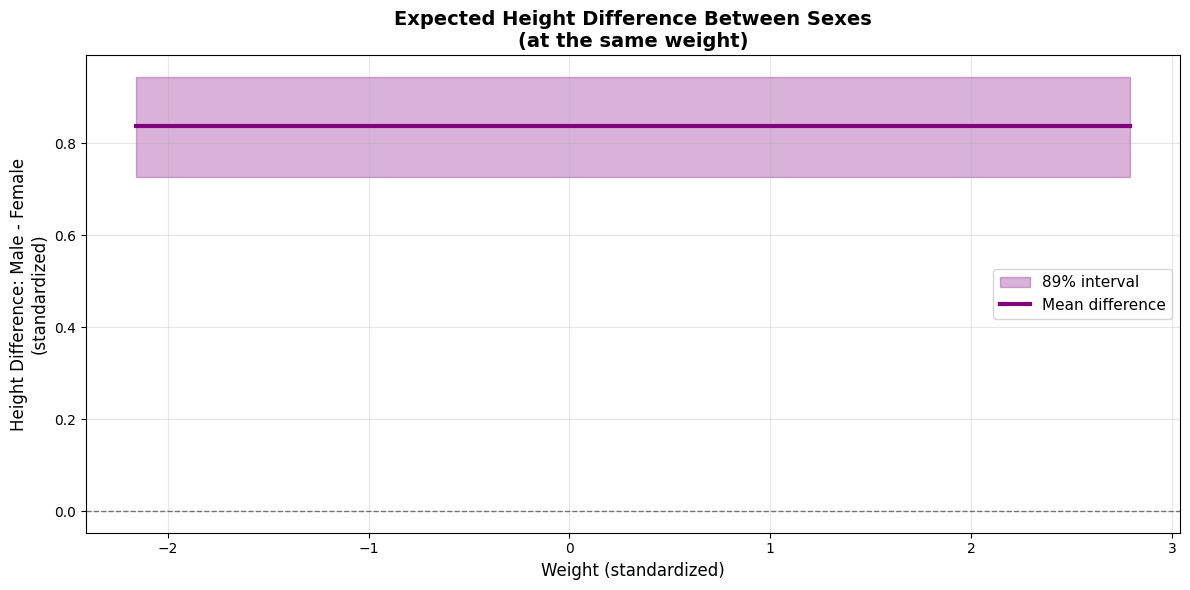


Expected height difference (original scale):
  At mean weight: 6.5 cm (males taller)
  Range: 6.5 to 6.5 cm

✓ The difference is roughly CONSTANT across all weights (parallel lines!)


In [14]:
# Compute the contrast (difference) at various weights
contrast_samples = mu_male_samples - mu_female_samples  # (1000, 100)

contrast_mean = contrast_samples.mean(axis=0)
contrast_lower = np.percentile(contrast_samples, 5.5, axis=0)
contrast_upper = np.percentile(contrast_samples, 94.5, axis=0)

# Plot the contrast
plt.figure(figsize=(12, 6))

plt.fill_between(weight_seq, contrast_lower, contrast_upper, 
                alpha=0.3, color='purple', label='89% interval')
plt.plot(weight_seq, contrast_mean, 'purple', linewidth=3, label='Mean difference')
plt.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)

plt.xlabel('Weight (standardized)', fontsize=12)
plt.ylabel('Height Difference: Male - Female\n(standardized)', fontsize=12)
plt.title('Expected Height Difference Between Sexes\n(at the same weight)', 
         fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Convert to original scale for interpretation
contrast_mean_orig = contrast_mean * height_std_orig

print(f"\nExpected height difference (original scale):")
print(f"  At mean weight: {contrast_mean_orig[50]:.1f} cm (males taller)")
print(f"  Range: {contrast_mean_orig.min():.1f} to {contrast_mean_orig.max():.1f} cm")
print("\n✓ The difference is roughly CONSTANT across all weights (parallel lines!)")

---

## Step 6: Why Index Variables?

**Index variable approach** (what we used):
```python
α[1] ~ Normal(0, 1)  # Male
α[2] ~ Normal(0, 1)  # Female
μ = α[sex[i]] + β*weight
```

**Dummy variable approach** (traditional):
```python
α ~ Normal(0, 1)      # Baseline (e.g., Female)
β_male ~ Normal(0, 1) # Difference for males
μ = α + β_male*is_male + β*weight
```

### Advantages of Index Variables:

1. **Symmetric priors**: Each category treated equally
2. **No arbitrary baseline**: Don't have to pick a reference category
3. **Easy to extend**: Adding more categories is straightforward
4. **Clearer interpretation**: Direct estimates for each group
5. **Better for hierarchical models**: Natural extension to varying effects

### When to use each:
- **Index variables**: Default choice, especially for >2 categories
- **Dummy variables**: When you specifically want to test against a control group

---

## Step 7: Extending to More Categories

Let's demonstrate how easy it is to extend index variables to more categories.

**Simulated example**: Height varies by age group AND sex

In [15]:
# Simulate data with 3 age groups
np.random.seed(42)
n_sim = 300

# Create age groups: 1=young, 2=middle, 3=old
age_group = np.random.choice([1, 2, 3], size=n_sim)
sex_sim = np.random.choice([1, 2], size=n_sim)

# Simulate heights with different means for each group
# Young: 170cm, Middle: 175cm, Old: 172cm (shrinkage)
# Males +8cm taller
base_height = np.array([170, 175, 172])[age_group - 1]
sex_effect = np.where(sex_sim == 1, 8, 0)
height_sim = base_height + sex_effect + np.random.normal(0, 5, n_sim)

# Standardize
height_sim_std = (height_sim - height_sim.mean()) / height_sim.std()

print(f"Simulated {n_sim} observations")
print(f"Age groups: {np.unique(age_group, return_counts=True)[1]}")
print(f"Sex: Male={np.sum(sex_sim==1)}, Female={np.sum(sex_sim==2)}")

Simulated 300 observations
Age groups: [ 99  94 107]
Sex: Male=135, Female=165


In [16]:
# Model with 3 age groups + 2 sexes using index variables
def neg_log_posterior_multi_category(params):
    # 3 age group parameters + 2 sex parameters + sigma
    alpha_age1, alpha_age2, alpha_age3, beta_sex1, beta_sex2, log_sigma = params
    sigma = np.exp(log_sigma)
    
    # Index into age group parameters
    alpha_age = np.array([alpha_age1, alpha_age2, alpha_age3])[age_group - 1]
    
    # Index into sex parameters
    beta_sex = np.where(sex_sim == 1, beta_sex1, beta_sex2)
    
    # Combine: base height by age + sex effect
    mu = alpha_age + beta_sex
    
    # Likelihood
    log_lik = np.sum(stats.norm.logpdf(height_sim_std, loc=mu, scale=sigma))
    
    # Priors
    log_prior = (stats.norm.logpdf(alpha_age1, 0, 1) +
                 stats.norm.logpdf(alpha_age2, 0, 1) +
                 stats.norm.logpdf(alpha_age3, 0, 1) +
                 stats.norm.logpdf(beta_sex1, 0, 1) +
                 stats.norm.logpdf(beta_sex2, 0, 1) +
                 stats.expon.logpdf(sigma, scale=1))
    
    return -(log_lik + log_prior + log_sigma)

m_multi = quap(neg_log_posterior_multi_category, 
               [0, 0, 0, 0, 0, np.log(1)], 
               ['alpha_young', 'alpha_middle', 'alpha_old', 
                'beta_male', 'beta_female', 'log_sigma'])
m_multi.transform_param('log_sigma', 'sigma', np.exp)

print("Model: Height ~ Age Group + Sex")
print("="*70)
m_multi.summary()

✓ Registered transformation: log_sigma -> sigma
Model: Height ~ Age Group + Sex
QUAP POSTERIOR APPROXIMATION
Converged: True
Time: 0.0443 seconds
Log posterior at MAP: -361.27

                mean    std  89%_lower  89%_upper
alpha_young  -0.2228 0.4568    -0.9559     0.5108
alpha_middle  0.4117 0.4557    -0.3200     1.1490
alpha_old    -0.1102 0.4553    -0.8384     0.6177
beta_male     0.5699 0.4540    -0.1590     1.2958
beta_female  -0.4959 0.4538    -1.2248     0.2250
sigma         0.7918 0.0323     0.7415     0.8444


,mean,std,89%_lower,89%_upper
alpha_young,-0.222776,0.456796,-0.955944,0.510789
alpha_middle,0.411725,0.455733,-0.319975,1.149038
alpha_old,-0.110203,0.455284,-0.838412,0.617677
beta_male,0.569895,0.454036,-0.159009,1.295812
beta_female,-0.495930,0.453765,-1.224823,0.225025
sigma,0.791767,0.032276,0.741543,0.844376


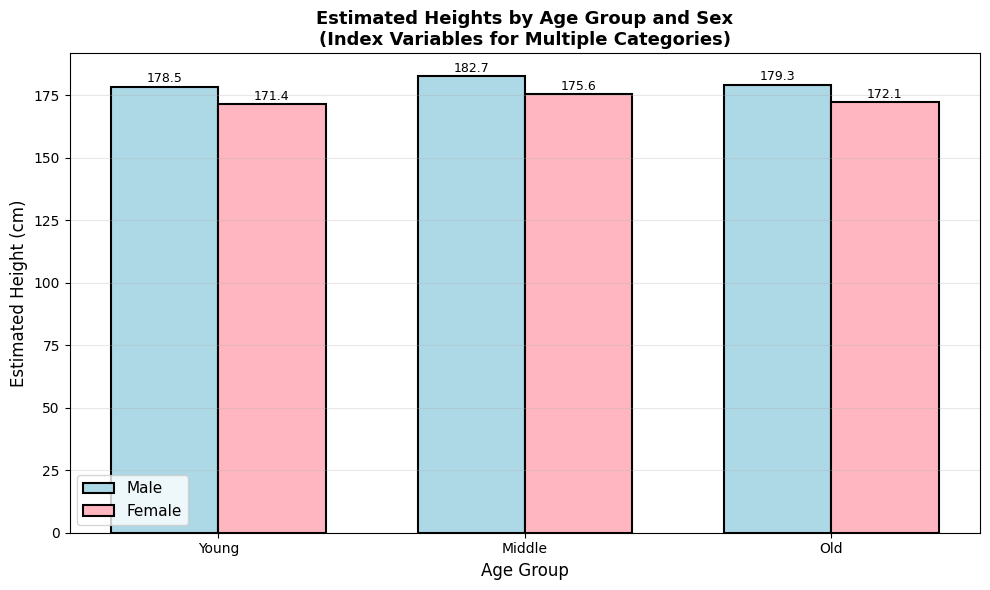


✓ Index variables make it easy to handle multiple categories!
  Each combination gets a clear, interpretable estimate.


In [17]:
# Visualize the multi-category results
coef_multi = m_multi.coef()

# Convert to original scale
height_sim_mean = height_sim.mean()
height_sim_std_val = height_sim.std()

age_labels = ['Young', 'Middle', 'Old']
age_effects = [coef_multi['alpha_young'], coef_multi['alpha_middle'], coef_multi['alpha_old']]
sex_effects = [coef_multi['beta_male'], coef_multi['beta_female']]

# Compute expected heights for each combination
heights_grid = np.zeros((3, 2))  # 3 age groups x 2 sexes
for i in range(3):
    for j in range(2):
        h_std = age_effects[i] + sex_effects[j]
        heights_grid[i, j] = h_std * height_sim_std_val + height_sim_mean

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(3)
width = 0.35

bars1 = ax.bar(x - width/2, heights_grid[:, 0], width, label='Male',
              color='lightblue', edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x + width/2, heights_grid[:, 1], width, label='Female',
              color='lightpink', edgecolor='black', linewidth=1.5)

ax.set_ylabel('Estimated Height (cm)', fontsize=12)
ax.set_xlabel('Age Group', fontsize=12)
ax.set_title('Estimated Heights by Age Group and Sex\n(Index Variables for Multiple Categories)', 
            fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(age_labels)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
               f'{height:.1f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("\n✓ Index variables make it easy to handle multiple categories!")
print("  Each combination gets a clear, interpretable estimate.")

---

## Summary

### What We Learned

**1. Index Variable Approach**
- Each category gets its own parameter: α[category]
- No dummy variables, no arbitrary baseline
- Symmetric priors for all categories

**2. Multiple Regression with Categorical + Continuous**
- μ = α[sex] + β*weight
- Different intercepts, same slope (parallel lines)
- Can easily compute contrasts between categories

**3. Implementation in Code**
```python
# Index into parameters
mu = np.where(sex == 1, alpha_1, alpha_2) + beta * weight

# Or for multiple categories
alpha_vec = np.array([alpha_1, alpha_2, alpha_3])
mu = alpha_vec[category - 1] + beta * x
```

**4. Why This Matters**
- Clearer interpretation
- Easier to extend to more categories
- Foundation for hierarchical/multilevel models
- Better for Bayesian modeling

**5. Key Results from Our Analysis**
- Males are taller than females at the same weight
- Weight has a strong positive effect on height (same for both sexes)
- The sex difference is roughly constant across all weights

---

**End of Chapter 5: Categorical Variables**